In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 과제
* 전이학습으로 강아지와 고양이 구분하기
* https://www.kaggle.com/competitions/dogs-vs-cats/data?select=test1.zip

In [3]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-06-20 05:33:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.141.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.4’

cats_and_dogs_filte 100%[===================>]  65.43M   249MB/s    in 0.3s    

2023-06-20 05:33:50 (249 MB/s) - ‘cats_and_dogs_filtered.zip.4’ saved [68606236/68606236]



In [4]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('catdog/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('catdog/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=True
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

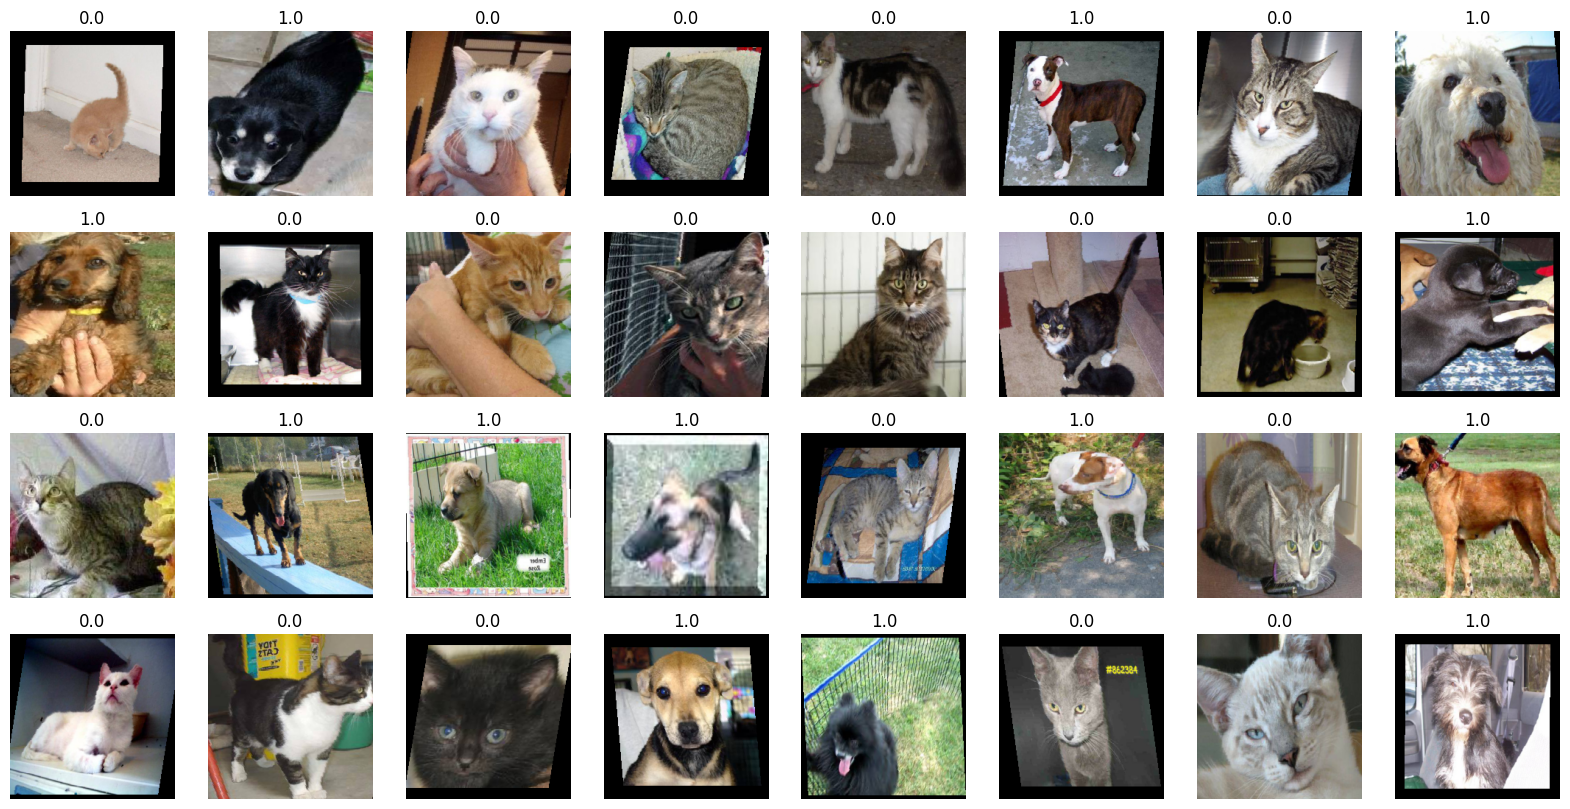

In [8]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4,8,figsize=(20,10))
for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))
  ax.axis('off')

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(W, b)를 업데이트 하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()
).to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습 : fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train', 'validation']:
    if phase =='train':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}')


train     : Epoch    1/10, Loss: 0.2023, Accuracy: 91.57
validation: Epoch    1/10, Loss: 0.0611, Accuracy: 98.24
train     : Epoch    2/10, Loss: 0.1074, Accuracy: 95.78
validation: Epoch    2/10, Loss: 0.0418, Accuracy: 98.63
train     : Epoch    3/10, Loss: 0.0983, Accuracy: 96.48
validation: Epoch    3/10, Loss: 0.0345, Accuracy: 99.02
train     : Epoch    4/10, Loss: 0.1054, Accuracy: 95.93
validation: Epoch    4/10, Loss: 0.0639, Accuracy: 97.46
train     : Epoch    5/10, Loss: 0.1014, Accuracy: 95.88
validation: Epoch    5/10, Loss: 0.1843, Accuracy: 93.16
train     : Epoch    6/10, Loss: 0.0558, Accuracy: 98.07
validation: Epoch    6/10, Loss: 0.0317, Accuracy: 99.02
train     : Epoch    7/10, Loss: 0.0743, Accuracy: 97.37
validation: Epoch    7/10, Loss: 0.0346, Accuracy: 99.02
train     : Epoch    8/10, Loss: 0.0636, Accuracy: 97.52
validation: Epoch    8/10, Loss: 0.0299, Accuracy: 98.93
train     : Epoch    9/10, Loss: 0.0662, Accuracy: 97.42
validation: Epoch    9/10, Loss

In [ ]:
torch.save(model.state_dict(), 'model.h5')

In [14]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

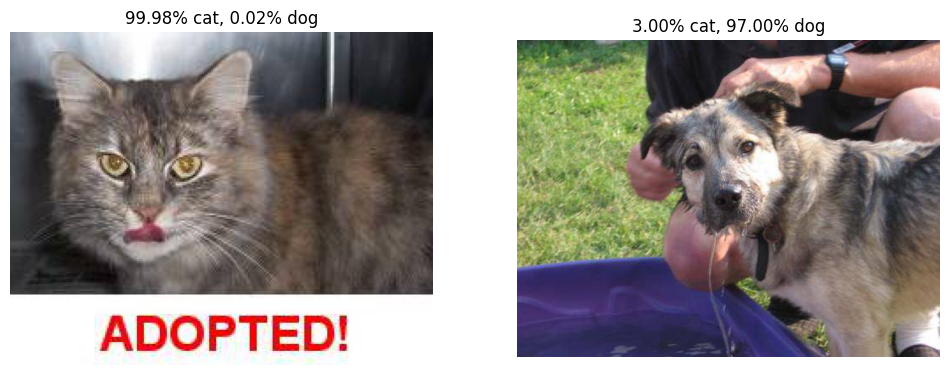

In [15]:
# 테스트
from PIL import Image
img1 = Image.open('/content/catdog/validation/cats/cat.2003.jpg')
img2 = Image.open('/content/catdog/validation/dogs/dog.2004.jpg')
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
y_pred = model(test_batch)
fig, axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% cat, {y_pred[0,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% cat, {y_pred[1,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가
plt.show()